In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 1 - Data preparation

## 1.1 - Read and shuffle data

In [11]:
df = pd.read_csv('vegemite.csv')

df = df.sample(n=len(df)).reset_index(drop=True)

df.to_csv('vegemite_shuffled.csv', index=False)

df.shape

(15237, 47)

## 1.2 - Create training set with 1002 data points

In [12]:
df = pd.read_csv('vegemite_shuffled.csv')

df_train, df_real_test = train_test_split(df, test_size=1000, stratify=df['Class'], random_state=42)

print(f"Number of rows in the test/validation set: {df_real_test.shape[0]}")
print(f"Number of rows in the training set: {df_train.shape[0]}")

df_real_test.to_csv('vegemite_realtime_test.csv', index=False)

Number of rows in the test/validation set: 1000
Number of rows in the training set: 14237


## 1.3 - Remove columns with constants

In [13]:
constant_columns = [col for col in df_train.columns if df_train[col].nunique() == 1]

# Remove those columns
df_train = df_train.drop(columns=constant_columns)

print("Columns removed:", constant_columns)

Columns removed: ['TFE Steam temperature SP', 'TFE Product out temperature']


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14237 entries, 8318 to 1780
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   FFTE Feed tank level SP        14237 non-null  float64
 1   FFTE Production solids SP      14237 non-null  float64
 2   FFTE Steam pressure SP         14237 non-null  float64
 3   TFE Out flow SP                14237 non-null  float64
 4   TFE Production solids SP       14237 non-null  float64
 5   TFE Vacuum pressure SP         14237 non-null  float64
 6   TFE Steam pressure SP          14237 non-null  float64
 7   FFTE Feed flow SP              14237 non-null  float64
 8   FFTE Out steam temp SP         14237 non-null  float64
 9   Extract tank Level             14237 non-null  float64
 10  Extract tank Out flow PV       14237 non-null  float64
 11  FFTE Discharge density         14237 non-null  float64
 12  FFTE Discharge solids          14237 non-null  fl

In [15]:
# Define the threshold for "few" unique values (e.g., 10 or fewer)
threshold = 10

# Identify integer columns with few unique values
cols_to_convert = [col for col in df_train.columns if col != 'Class' and df_train[col].nunique() <= threshold]

cols_to_convert  

['FFTE Feed tank level SP',
 'FFTE Pump 1',
 'FFTE Pump 1 - 2',
 'FFTE Pump 2',
 'TFE Motor speed']

In [16]:
label_encoders = {}

for col in cols_to_convert:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    label_encoders[col] = le

df_train.to_csv('vegemite_converted.csv', index = False)

## 1.4 - Check class distribution

C:\Users\Admin\AppData\Local\Temp\ipykernel_1904\4048237079.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


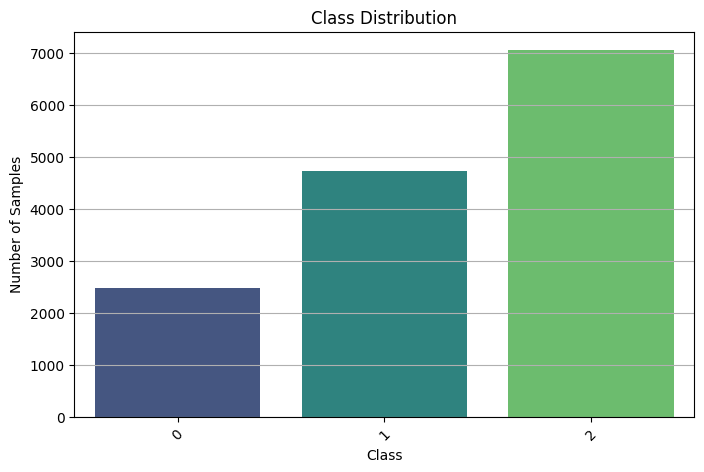

In [17]:
class_distribution = df_train['Class'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')

# Adding titles and labels
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)  # Rotate class labels for better readability
plt.grid(axis='y')

# Show the plot
plt.show()

In [18]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from collections import Counter

X = df_train.drop('Class', axis=1)
y = df_train['Class']

print(f"Initial class distribution:\n{Counter(y)}")

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

tomek_links = TomekLinks()
X_balanced, y_balanced = tomek_links.fit_resample(X_smote, y_smote)

print(f"Class distribution after SMOTE and Tomek Links:\n{Counter(y_balanced)}")

df_train = pd.concat([pd.DataFrame(X_balanced, columns=X.columns), pd.Series(y_balanced, name='Class')], axis=1)

Initial class distribution:
Counter({2: 7053, 1: 4716, 0: 2468})
Class distribution after SMOTE and Tomek Links:
Counter({0: 7053, 1: 6959, 2: 6932})


## 1.5 - Data normalization

In [19]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
FFTE Feed tank level SP,20944.0,1.745846,0.658819,0.00,2.000000,2.000000,2.000000,2.00
FFTE Production solids SP,20944.0,41.776407,1.114452,39.00,40.740000,42.000000,43.000000,43.00
FFTE Steam pressure SP,20944.0,118.195096,16.261832,60.00,106.977454,120.000000,128.906711,225.00
TFE Out flow SP,20944.0,2405.277913,386.500337,1687.18,2066.670000,2240.020000,2846.510000,3012.56
TFE Production solids SP,20944.0,62.537359,14.333315,0.00,62.000000,65.000000,70.000000,98.00
TFE Vacuum pressure SP,20944.0,-65.974585,13.306496,-80.00,-78.479557,-69.871206,-55.312601,-36.37
TFE Steam pressure SP,20944.0,115.185251,24.148179,2.00,120.000000,120.000000,120.000000,135.00
FFTE Feed flow SP,20944.0,9972.302091,1332.316798,1100.00,9400.000000,9600.000000,10200.000000,18000.00
FFTE Out steam temp SP,20944.0,49.713776,1.915526,40.71,50.000000,50.000000,50.000000,54.38
Extract tank Level,20944.0,47.521566,18.324433,0.62,37.622235,52.160000,62.130000,75.62


In [20]:
from sklearn.preprocessing import MinMaxScaler

features = df_train.drop(columns=['Class'])
target = df_train['Class']

# Min-Max Scaling
scaler = MinMaxScaler()
min_max_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

# Combine the scaled features back with the target column
df_scaled = min_max_scaled.copy()
df_scaled['Class'] = target.values

df_train = df_scaled

# Display the first few rows of the scaled DataFrame
df_train.head()

,FFTE Feed tank level SP,FFTE Production solids SP,FFTE Steam pressure SP,TFE Out flow SP,TFE Production solids SP,TFE Vacuum pressure SP,TFE Steam pressure SP,FFTE Feed flow SP,FFTE Out steam temp SP,Extract tank Level,...,TFE Motor speed,TFE Out flow PV,TFE Production solids PV,TFE Production solids density,TFE Steam pressure PV,TFE Steam temperature,TFE Tank level,TFE Temperature,TFE Vacuum pressure PV,Class
0,1.0,0.375,0.303030,0.326171,0.612245,0.099244,0.887218,0.481065,0.679590,0.886533,...,1.0,0.154184,0.538588,0.750000,0.785604,0.347639,0.861821,0.36,0.089060,0
1,1.0,1.000,0.454545,0.695740,0.724490,1.000000,0.887218,0.544379,0.688369,0.759200,...,1.0,0.150956,0.605326,0.826087,0.709779,0.428725,0.912122,0.32,0.131721,2
2,1.0,0.750,0.424242,0.063567,0.775510,0.023149,0.924812,0.485207,0.679590,0.750000,...,1.0,0.102934,0.745952,0.728261,0.709779,0.376150,0.862999,0.26,0.092908,0
3,1.0,1.000,0.484848,0.695740,0.632653,0.032317,0.887218,0.532544,0.708851,0.746267,...,1.0,0.124080,0.773979,0.760870,0.709779,0.403280,0.857816,0.38,0.170643,1
4,0.0,0.750,0.454545,0.397705,0.051020,0.687600,0.000000,0.763314,0.679590,0.692933,...,1.0,0.102571,0.744144,0.423913,0.707825,0.556101,0.850630,0.40,0.189775,2


# 2 - Feature engineering

In [21]:
df_train.shape

(20944, 45)

## 2.1 - Correlation matrix analysis

In [22]:
corr = abs(df_train.corr()).T

corr

,FFTE Feed tank level SP,FFTE Production solids SP,FFTE Steam pressure SP,TFE Out flow SP,TFE Production solids SP,TFE Vacuum pressure SP,TFE Steam pressure SP,FFTE Feed flow SP,FFTE Out steam temp SP,Extract tank Level,...,TFE Motor speed,TFE Out flow PV,TFE Production solids PV,TFE Production solids density,TFE Steam pressure PV,TFE Steam temperature,TFE Tank level,TFE Temperature,TFE Vacuum pressure PV,Class
FFTE Feed tank level SP,1.000000,0.081780,0.226483,0.030155,0.300561,0.272033,0.532396,0.487044,0.024773,0.063440,...,0.274288,0.137878,0.257912,0.043594,0.199721,0.026078,0.078583,0.029521,0.261664,0.047075
FFTE Production solids SP,0.081780,1.000000,0.050145,0.553075,0.319449,0.201569,0.095787,0.269541,0.081900,0.030865,...,0.056663,0.004755,0.073323,0.050228,0.025999,0.048561,0.041496,0.058702,0.074523,0.132877
FFTE Steam pressure SP,0.226483,0.050145,1.000000,0.056359,0.034629,0.105402,0.303996,0.281959,0.077154,0.057036,...,0.151586,0.039635,0.167473,0.042138,0.122599,0.034203,0.103829,0.001286,0.145065,0.094467
TFE Out flow SP,0.030155,0.553075,0.056359,1.000000,0.285222,0.264990,0.062322,0.313405,0.009766,0.044194,...,0.082896,0.043271,0.003426,0.003382,0.028822,0.050788,0.060366,0.048080,0.078136,0.186650
TFE Production solids SP,0.300561,0.319449,0.034629,0.285222,1.000000,0.160954,0.360983,0.282107,0.022602,0.008041,...,0.007504,0.015988,0.048961,0.021624,0.024108,0.023941,0.046322,0.020823,0.005847,0.018125
TFE Vacuum pressure SP,0.272033,0.201569,0.105402,0.264990,0.160954,1.000000,0.234596,0.301502,0.022172,0.000045,...,0.111653,0.069064,0.092772,0.009376,0.109570,0.045980,0.001512,0.067715,0.148744,0.115156
TFE Steam pressure SP,0.532396,0.095787,0.303996,0.062322,0.360983,0.234596,1.000000,0.828066,0.046388,0.013500,...,0.300488,0.155422,0.324191,0.119415,0.239454,0.079934,0.061915,0.035193,0.261321,0.007423
FFTE Feed flow SP,0.487044,0.269541,0.281959,0.313405,0.282107,0.301502,0.828066,1.000000,0.047014,0.004070,...,0.279293,0.158929,0.289926,0.100230,0.221714,0.043183,0.069253,0.003892,0.261855,0.109490
FFTE Out steam temp SP,0.024773,0.081900,0.077154,0.009766,0.022602,0.022172,0.046388,0.047014,1.000000,0.015974,...,0.015699,0.037404,0.005109,0.058854,0.046104,0.024042,0.038748,0.026580,0.027354,0.048180
Extract tank Level,0.063440,0.030865,0.057036,0.044194,0.008041,0.000045,0.013500,0.004070,0.015974,1.000000,...,0.166496,0.123880,0.111197,0.077713,0.112995,0.041985,0.113720,0.002320,0.141200,0.052814


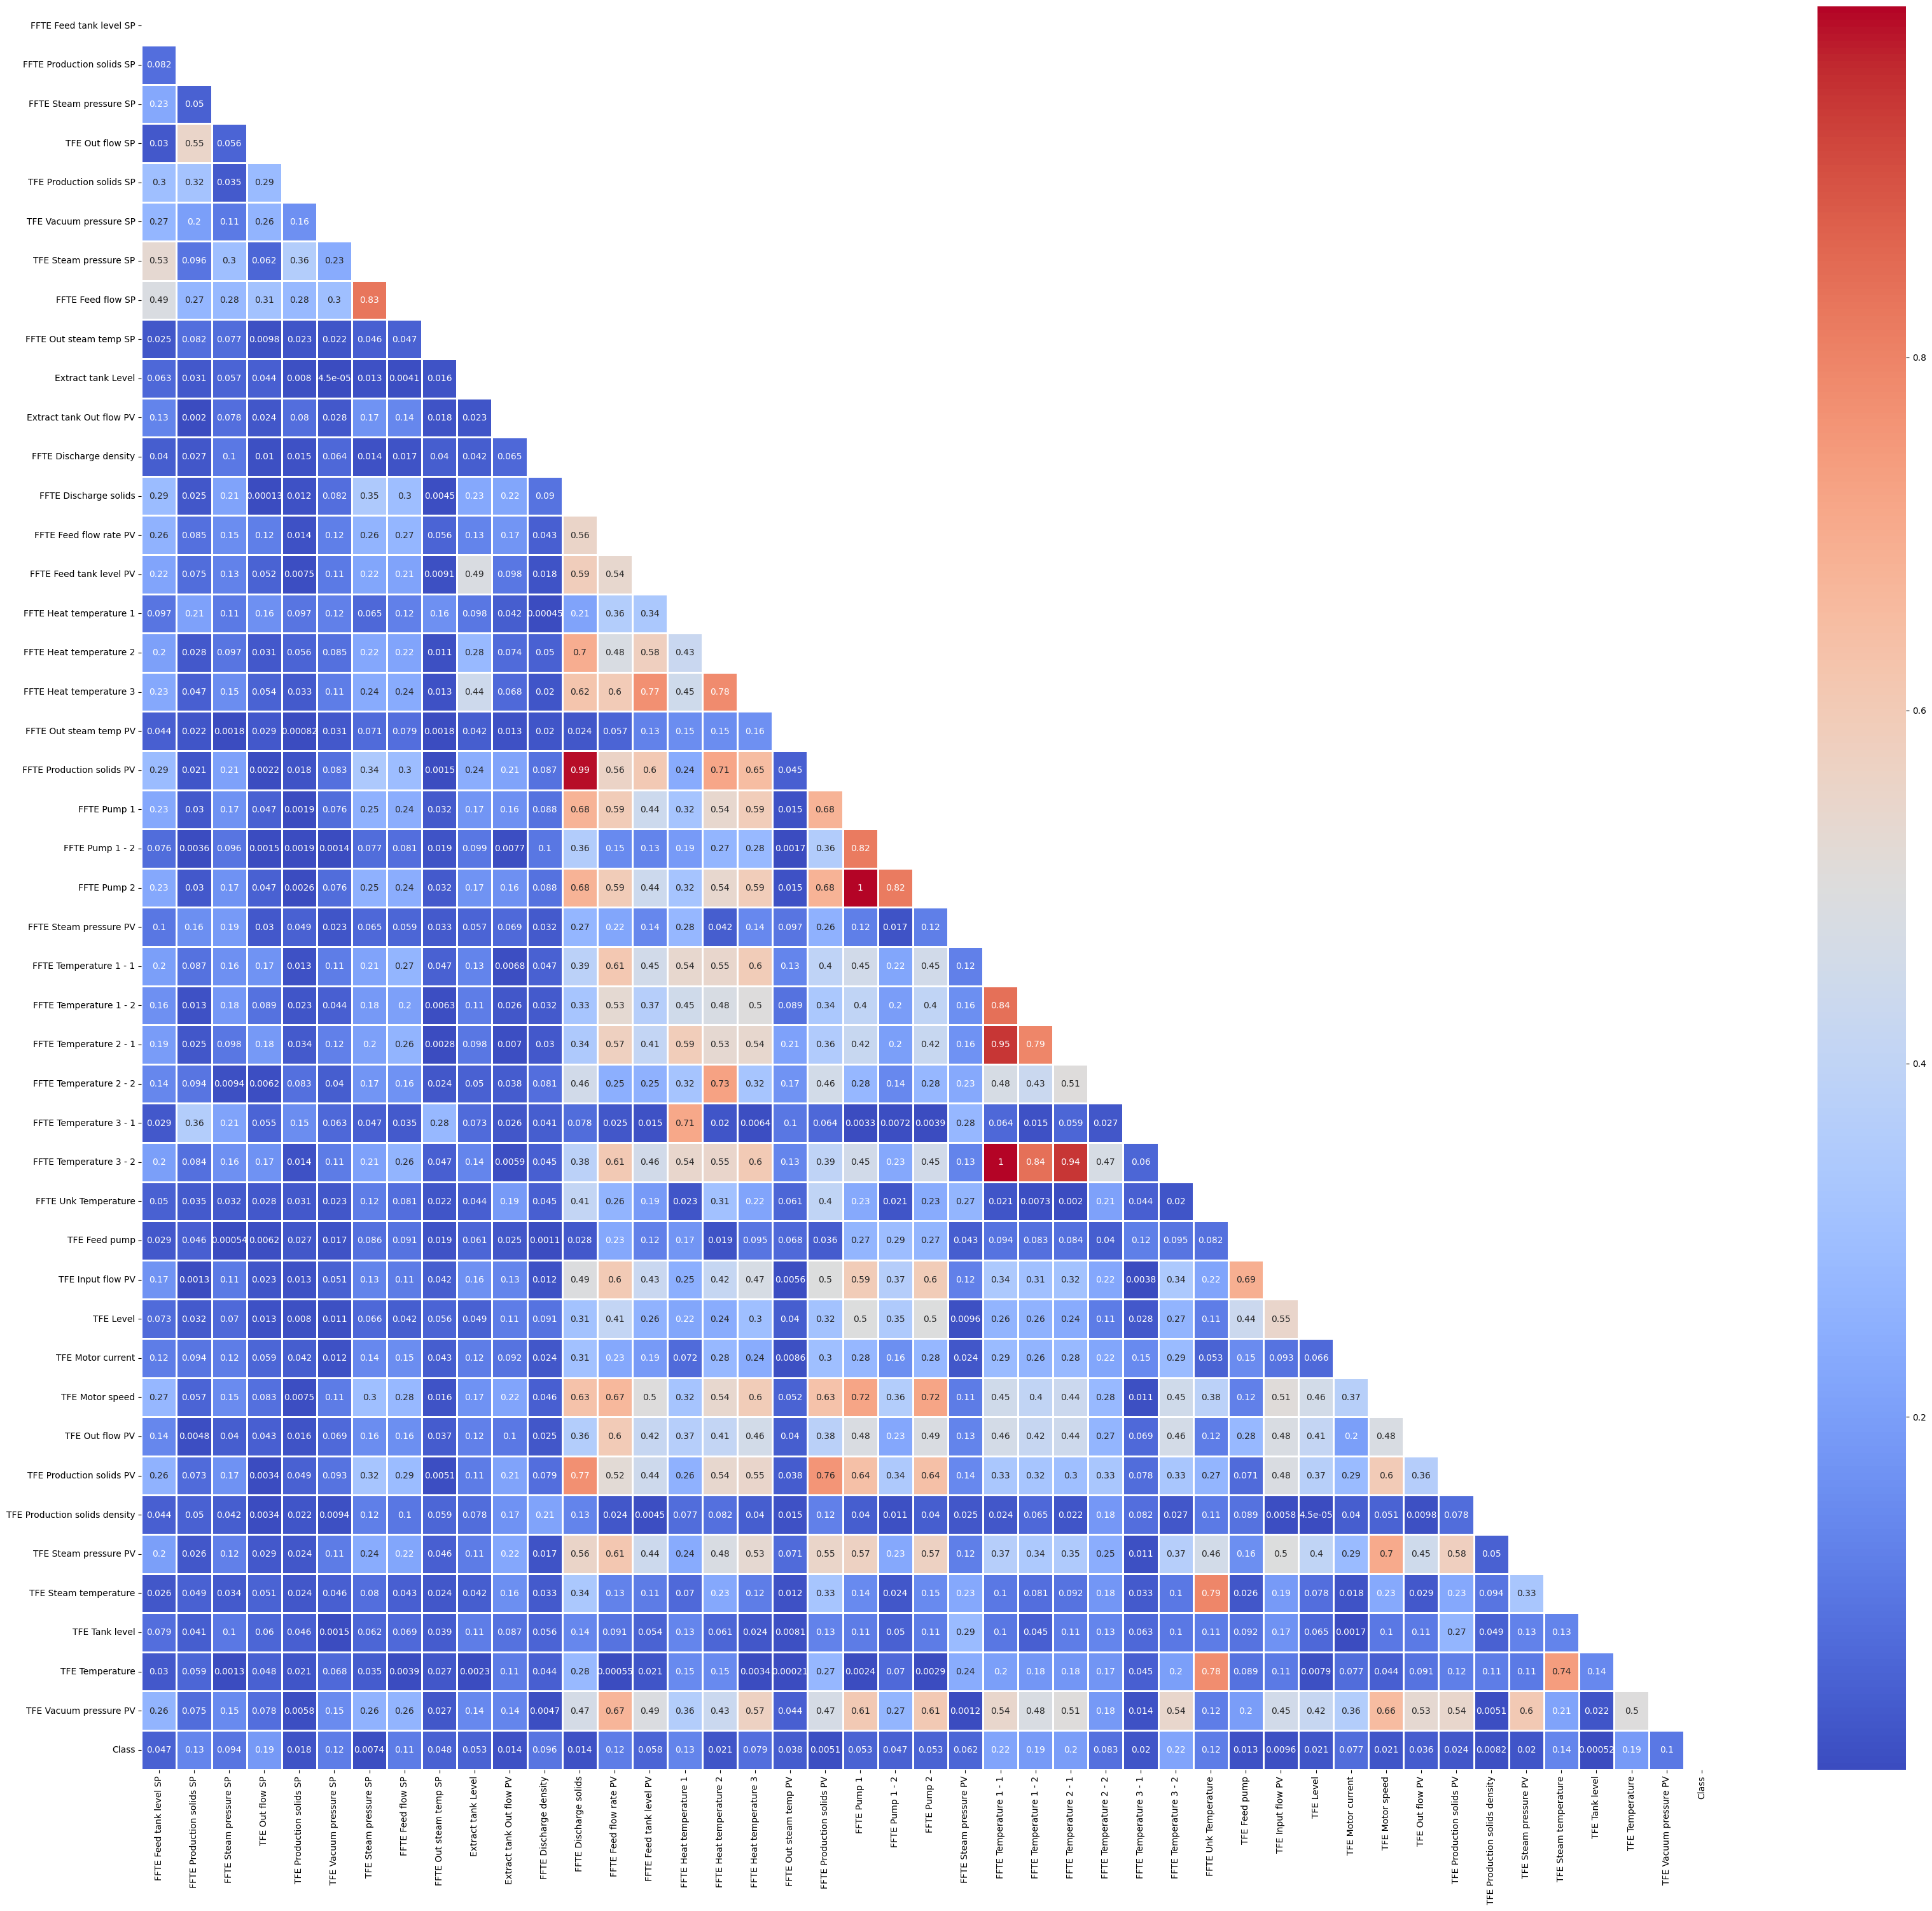

In [23]:
import seaborn as sns

corr = abs(df_train.corr())
lower_triangle = np.tril(corr, k=-1)
mask = lower_triangle == 0

plt.figure(figsize=(40, 36))
sns.heatmap(corr, center=0.5, cmap='coolwarm', annot=True, 
            xticklabels=corr.columns, yticklabels=corr.columns, 
            cbar=True, linewidths=1, mask=mask)
plt.show()

## 2.2 - Create composite features based on correlation

In [24]:
threshold = 0.1
corr_matrix = df_train.corr()

# Get the correlation of each feature with the target column
target_corr = corr_matrix['Class']

# # Find features with small positive correlations with the target column
small_positive_corr = target_corr[(target_corr > 0) & (target_corr <= threshold)].index.tolist()

# Filter the correlation matrix to include only the small positive correlations
filtered_corr_matrix = corr_matrix.loc[small_positive_corr, small_positive_corr]

pairs = []

for i, feature in enumerate(small_positive_corr):
    for other_feature in small_positive_corr[i+1:]:
        if 0 < filtered_corr_matrix.loc[feature, other_feature] <= threshold:
            pairs.append((feature, other_feature))

len(small_positive_corr), len(pairs)

(16, 25)

In [25]:
for pair in pairs:
    feature1, feature2 = pair
    new_feature_name = f'{feature1}_{feature2}'
    df_train[new_feature_name] = df_train[feature1] + df_train[feature2]

df_train.to_csv('vegemite_composite.csv', index=False)

df_train.columns

Index(['FFTE Feed tank level SP', 'FFTE Production solids SP',
       'FFTE Steam pressure SP', 'TFE Out flow SP', 'TFE Production solids SP',
       'TFE Vacuum pressure SP', 'TFE Steam pressure SP', 'FFTE Feed flow SP',
       'FFTE Out steam temp SP', 'Extract tank Level',
       'Extract tank Out flow PV', 'FFTE Discharge density',
       'FFTE Discharge solids', 'FFTE Feed flow rate PV',
       'FFTE Feed tank level PV', 'FFTE Heat temperature 1',
       'FFTE Heat temperature 2', 'FFTE Heat temperature 3',
       'FFTE Out steam temp PV', 'FFTE Production solids PV', 'FFTE Pump 1',
       'FFTE Pump 1 - 2', 'FFTE Pump 2', 'FFTE Steam pressure PV',
       'FFTE Temperature 1 - 1', 'FFTE Temperature 1 - 2',
       'FFTE Temperature 2 - 1', 'FFTE Temperature 2 - 2',
       'FFTE Temperature 3 - 1', 'FFTE Temperature 3 - 2',
       'FFTE Unk Temperature', 'TFE Feed pump', 'TFE Input flow PV',
       'TFE Level', 'TFE Motor current', 'TFE Motor speed', 'TFE Out flow PV',
       'TFE P

In [26]:
cols =[col for col in df_train.columns]
len(cols)

70

## 2.3 - Feature Selection

In [27]:
df = pd.read_csv('vegemite_composite.csv')

df.head()

,FFTE Feed tank level SP,FFTE Production solids SP,FFTE Steam pressure SP,TFE Out flow SP,TFE Production solids SP,TFE Vacuum pressure SP,TFE Steam pressure SP,FFTE Feed flow SP,FFTE Out steam temp SP,Extract tank Level,...,FFTE Heat temperature 2_TFE Production solids density,FFTE Steam pressure PV_TFE Level,FFTE Temperature 2 - 2_TFE Feed pump,TFE Feed pump_TFE Production solids density,TFE Level_TFE Production solids density,TFE Motor current_TFE Production solids density,TFE Out flow PV_TFE Production solids density,TFE Production solids PV_TFE Production solids density,TFE Production solids density_TFE Steam pressure PV,TFE Production solids density_TFE Tank level
0,1.0,0.375,0.303030,0.326171,0.612245,0.099244,0.887218,0.481065,0.679590,0.886533,...,1.331322,0.936820,0.824455,1.016200,1.276066,1.152178,0.904184,1.288588,1.535604,1.611821
1,1.0,1.000,0.454545,0.695740,0.724490,1.000000,0.887218,0.544379,0.688369,0.759200,...,1.399365,0.821787,0.603766,0.938887,1.210072,1.184834,0.977043,1.431413,1.535866,1.738209
2,1.0,0.750,0.424242,0.063567,0.775510,0.023149,0.924812,0.485207,0.679590,0.750000,...,1.349214,0.850429,0.820156,0.998261,1.178103,1.113965,0.831195,1.474213,1.438039,1.591260
3,1.0,1.000,0.484848,0.695740,0.632653,0.032317,0.887218,0.532544,0.708851,0.746267,...,1.434011,0.867860,0.910083,1.030870,1.187311,1.211652,0.884949,1.534848,1.470648,1.618686
4,0.0,0.750,0.454545,0.397705,0.051020,0.687600,0.000000,0.763314,0.679590,0.692933,...,1.061739,0.890404,0.870631,0.691013,0.872175,0.833035,0.526484,1.168057,1.131738,1.274543


In [28]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['Class'])
y = df['Class']

#Standardize the features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Use the SelectKBest class to extract the top 10 features
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

# print the selected features
selected_features = X.columns[selector.get_support()]
print(selected_features)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

#Print the shape of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Index(['FFTE Production solids SP', 'TFE Out flow SP',
       'FFTE Heat temperature 1', 'FFTE Temperature 1 - 1',
       'FFTE Temperature 1 - 2', 'FFTE Temperature 2 - 1',
       'FFTE Temperature 3 - 2', 'FFTE Unk Temperature',
       'TFE Steam temperature', 'TFE Temperature'],
      dtype='object')


((14660, 10), (6284, 10), (14660,), (6284,))

## 2.4 - Model training

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


# Models initialization
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

# Train and evaluate each model
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Save evaluation metrics
    results[model_name] = {
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }


Training Logistic Regression...
Training Random Forest...
Training Decision Tree...
Training SVM...
Training KNN...


### Display Classification report

In [30]:
# Display classification report
for model_name, metrics in results.items():
    print(f"\n{model_name} Classification Report:\n")
    print(metrics['classification_report'])


Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.48      0.60      0.53      2148
           1       0.43      0.27      0.33      2047
           2       0.51      0.58      0.54      2089

    accuracy                           0.48      6284
   macro avg       0.48      0.48      0.47      6284
weighted avg       0.48      0.48      0.47      6284


Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2148
           1       0.97      0.96      0.97      2047
           2       0.98      0.99      0.98      2089

    accuracy                           0.98      6284
   macro avg       0.98      0.98      0.98      6284
weighted avg       0.98      0.98      0.98      6284


Decision Tree Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2148
      

## Display confusion matrix

In [31]:
# Display confusion matrix
for model_name, metrics in results.items():
    print(f"\n{model_name} Confusion Matrix:\n")
    print(metrics['confusion_matrix'])


Logistic Regression Confusion Matrix:

[[1282  347  519]
 [ 876  557  614]
 [ 487  399 1203]]

Random Forest Confusion Matrix:

[[2101   34   13]
 [  39 1972   36]
 [   6   25 2058]]

Decision Tree Confusion Matrix:

[[2054   51   43]
 [  77 1893   77]
 [  16   37 2036]]

SVM Confusion Matrix:

[[1723  243  182]
 [ 468 1168  411]
 [ 357  351 1381]]

KNN Confusion Matrix:

[[2012   82   54]
 [ 122 1772  153]
 [ 131  164 1794]]


### Visualize confusion matrix

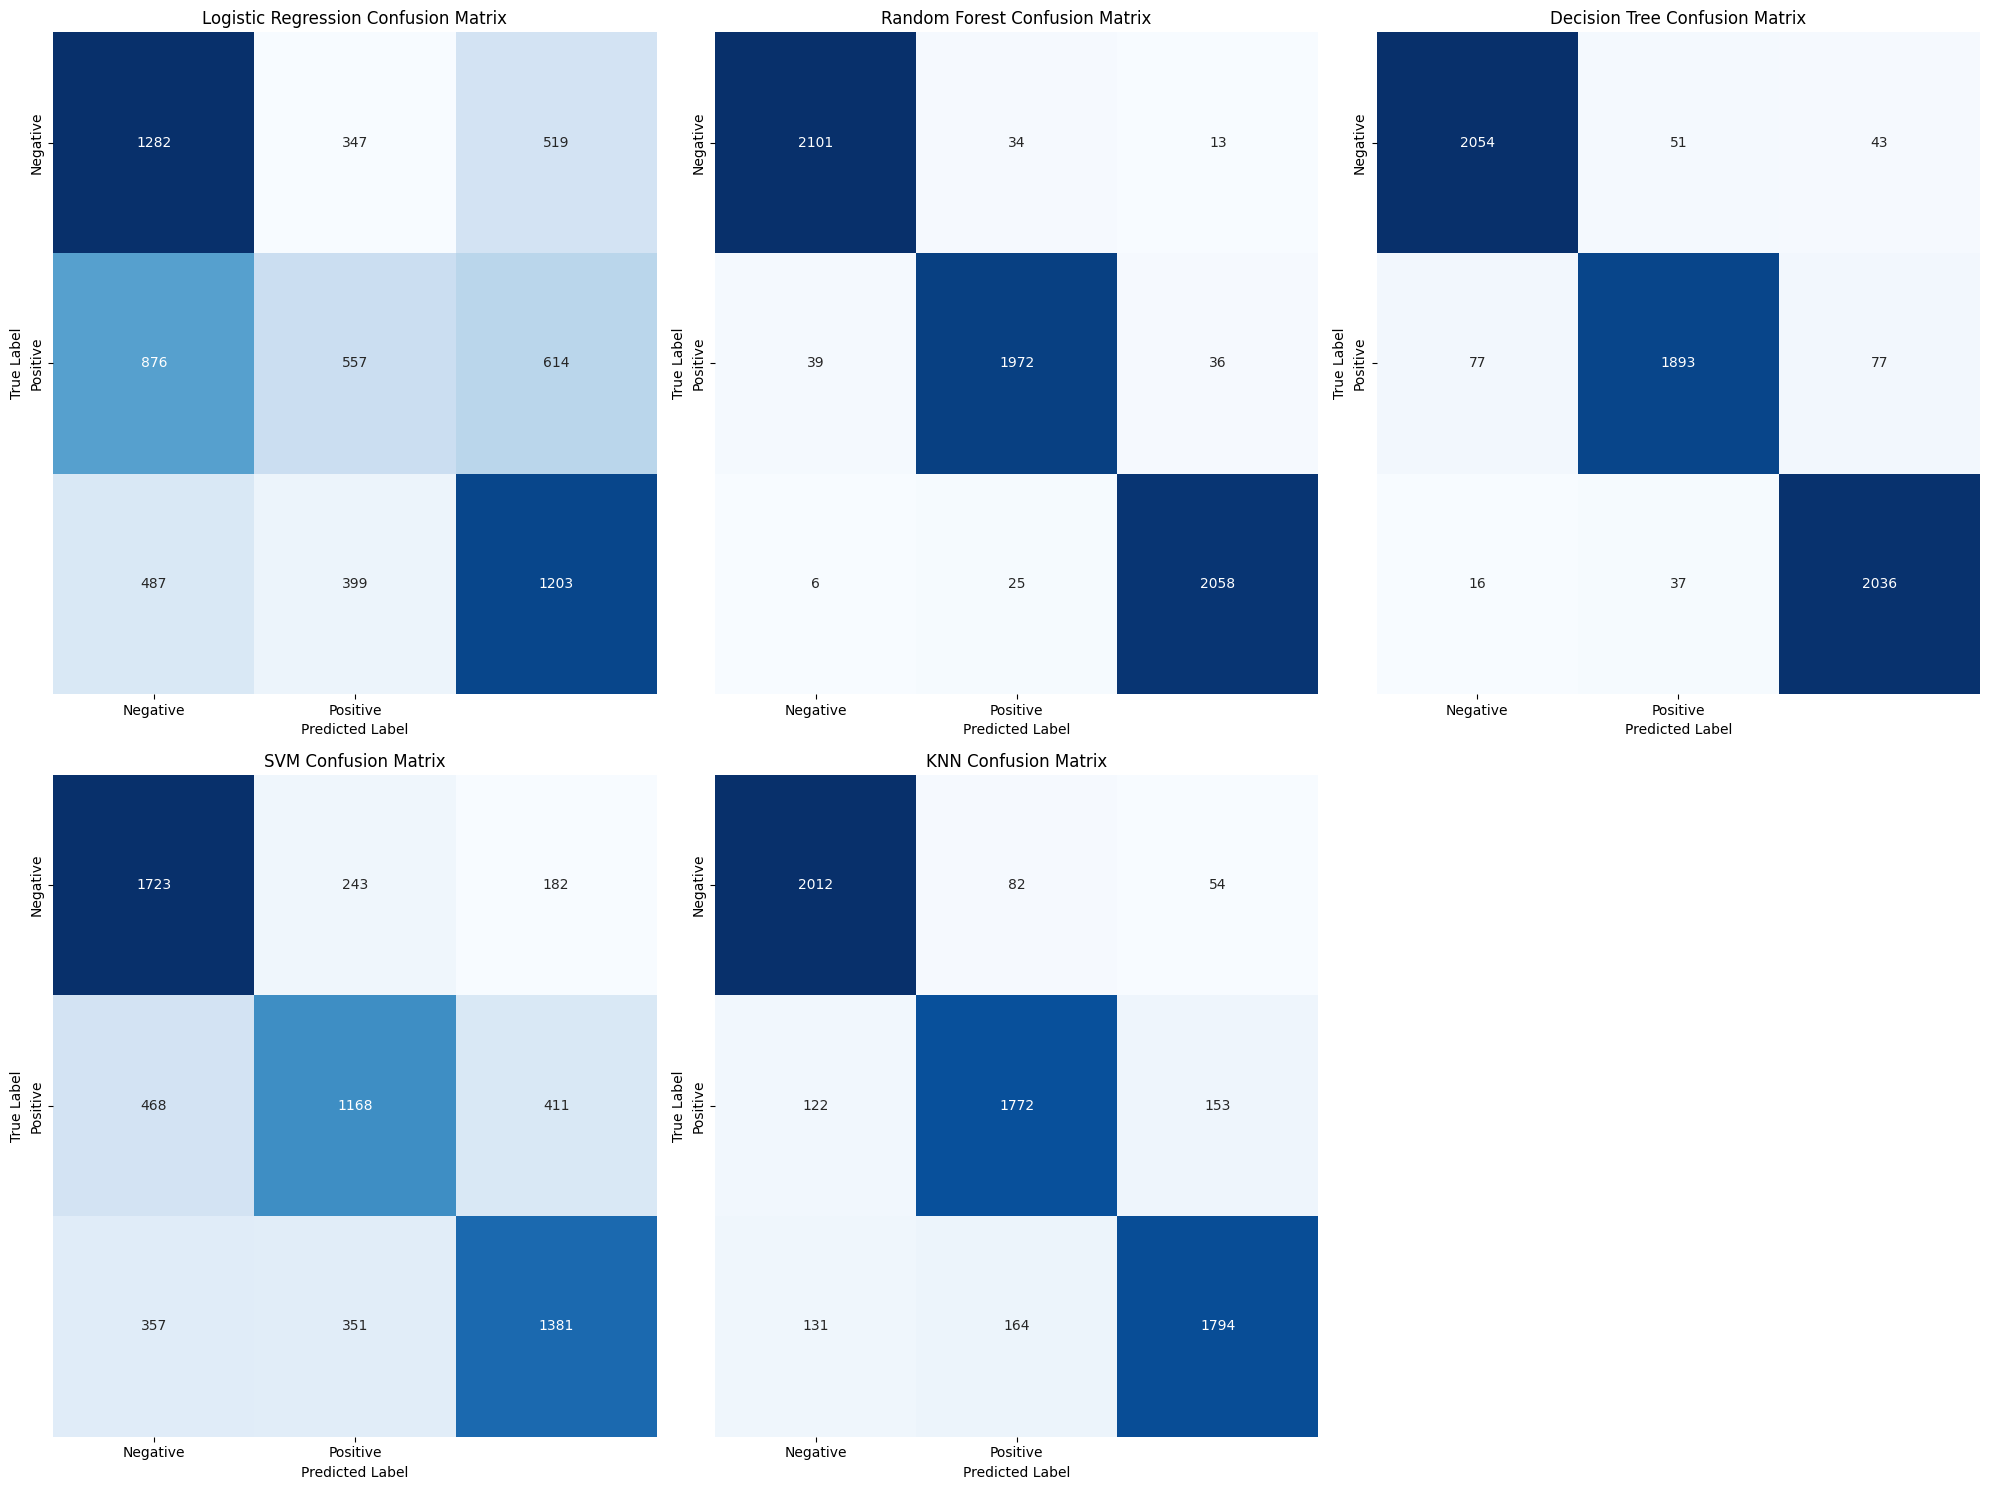

In [32]:
# Visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))
for i, (model_name, metrics) in enumerate(results.items()):
    plt.subplot(2, 3, i+1)
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()


### Save model

In [33]:
import pickle

filename = 'model/bestmodel.pkl'
pickle.dump(models['Random Forest'], open(filename, 'wb'))

for model_name, model in models.items():
    filename = f'model/{model_name}_model.pkl'
    pickle.dump(model, open(filename, 'wb'))

# 3 - ML to AI

In [34]:
test_df = pd.read_csv('vegemite_realtime_test.csv')

X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']

## Perform processing on test set

In [35]:
# Remove constant columns in the test set
X_test = X_test.drop(columns=constant_columns, errors='ignore')

# Convert integer columns with few unique values
for col in cols_to_convert:
    le = label_encoders[col]
    X_test[col] = le.transform(X_test[col])

# Create composite features
for pair in pairs:
    feature1, feature2 = pair
    new_feature_name = f'{feature1}_{feature2}'
    X_test[new_feature_name] = X_test[feature1] + X_test[feature2]

# Scale the features
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Select the top 10 features
X_test = X_test[selected_features]

X_test.head()

,FFTE Production solids SP,TFE Out flow SP,FFTE Heat temperature 1,FFTE Temperature 1 - 1,FFTE Temperature 1 - 2,FFTE Temperature 2 - 1,FFTE Temperature 3 - 2,FFTE Unk Temperature,TFE Steam temperature,TFE Temperature
0,151.848358,10003.602337,376.331889,566.118137,595.775682,861.198960,555.806761,575.874845,709.762298,647.491790
1,148.259063,7591.526713,497.085477,556.290817,607.731856,870.510973,567.682269,459.314525,554.480237,503.779865
2,151.848358,9759.575920,474.417846,615.004890,648.433722,901.357017,603.147219,547.449266,590.333712,632.364219
3,148.259063,7591.526713,519.163244,676.633847,702.024513,956.792597,664.302043,535.553780,653.907233,594.545292
4,151.848358,9596.891642,502.984117,694.039864,717.796487,937.586569,681.832554,538.025569,631.083841,586.981506


## Load and test the best model

In [36]:
from sklearn.metrics import classification_report

model = pickle.load(open('model/bestmodel.pkl', 'rb'))

# Initialize a counter for correct predictions
correct_count = 0

# Iterate through each row in the test data
for index, row in X_test.iterrows():
    x_i = row.values.reshape(1, -1)  # Convert the row to 2D (model expects 2D input)
    y_true = y_test.iloc[index]       # Get the true label for this row
    
    # Predict the label for the current row
    y_pred = model.predict(x_i)[0]    # [0] to extract the single predicted label
    
    # Compare predicted label with the true label
    if y_pred == y_true:
        correct_count += 1            # Increment correct count if prediction matches

# Calculate accuracy
accuracy = correct_count / len(y_test)

# Print the results
print(f"Correct classifications: {correct_count} out of {len(y_test)}")
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_test, model.predict(X_test)))


Correct classifications: 495 out of 1000
Accuracy: 0.4950
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       174
           1       0.00      0.00      0.00       331
           2       0.49      1.00      0.66       495

    accuracy                           0.49      1000
   macro avg       0.17      0.33      0.22      1000
weighted avg       0.25      0.49      0.33      1000



d:\Swinburne\COS40007 - Artificial Intelligence for Engineering\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
d:\Swinburne\COS40007 - Artificial Intelligence for Engineering\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Swinburne\COS40007 - Artificial Intelligence for Engineering\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Swinburne\COS40007 - Artificial Intelligence for E

## Other models

In [37]:
from sklearn.metrics import accuracy_score, classification_report

# List of models to test
model_paths = {
    'Decision Tree': 'model/Decision Tree_model.pkl',
    'Random Forest': 'model/Random Forest_model.pkl',
    'SVM': 'model/SVM_model.pkl',
    'KNN': 'model/KNN_model.pkl',
    'Logistic Regression': 'model/Logistic Regression_model.pkl'
}

# Dictionary to store the accuracy of each model
model_accuracies = {}
reports = {}

# Iterate over each model, load it, and evaluate
for model_name, model_path in model_paths.items():
    # Load the model
    model = pickle.load(open(model_path, 'rb'))
    
    # Make predictions for the entire test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Store the accuracy
    model_accuracies[model_name] = accuracy
    reports[model_name] = report
    

# Display the accuracies of all models
for model_name, accuracy in model_accuracies.items():
    print(f"{model_name} Accuracy: {accuracy:.4f}")

d:\Swinburne\COS40007 - Artificial Intelligence for Engineering\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
d:\Swinburne\COS40007 - Artificial Intelligence for Engineering\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Swinburne\COS40007 - Artificial Intelligence for Engineering\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Swinburne\COS40007 - Artificial Intelligence for E

Decision Tree Accuracy: 0.4950
Random Forest Accuracy: 0.4950
SVM Accuracy: 0.4950
KNN Accuracy: 0.3160
Logistic Regression Accuracy: 0.4950


d:\Swinburne\COS40007 - Artificial Intelligence for Engineering\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Swinburne\COS40007 - Artificial Intelligence for Engineering\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Swinburne\COS40007 - Artificial Intelligence for Engineering\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

#  4 - Develop rules from ML model

In [38]:
# Read dataset

df = pd.read_csv('vegemite_shuffled.csv')

X = df.drop(columns=['Class'])
y = df['Class']

#Select only columns with "SP" in the name
X = X.filter(like='SP')

X.columns

Index(['FFTE Feed tank level SP', 'FFTE Production solids SP',
       'FFTE Steam pressure SP', 'TFE Out flow SP', 'TFE Production solids SP',
       'TFE Vacuum pressure SP', 'TFE Steam pressure SP',
       'TFE Steam temperature SP', 'FFTE Feed flow SP',
       'FFTE Out steam temp SP'],
      dtype='object')

|--- TFE Out flow SP <= 2249.11
|   |--- FFTE Steam pressure SP <= 119.98
|   |   |--- TFE Out flow SP <= 2100.70
|   |   |   |--- TFE Vacuum pressure SP <= -67.99
|   |   |   |   |--- FFTE Feed flow SP <= 9395.00
|   |   |   |   |   |--- TFE Production solids SP <= 64.25
|   |   |   |   |   |   |--- FFTE Steam pressure SP <= 103.50
|   |   |   |   |   |   |   |--- FFTE Steam pressure SP <= 94.00
|   |   |   |   |   |   |   |   |--- TFE Production solids SP <= 52.75
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- TFE Production solids SP >  52.75
|   |   |   |   |   |   |   |   |   |--- TFE Production solids SP <= 60.00
|   |   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |   |--- TFE Production solids SP >  60.00
|   |   |   |   |   |   |   |   |   |   |--- TFE Vacuum pressure SP <= -76.47
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- TFE Vacuum pressure SP 

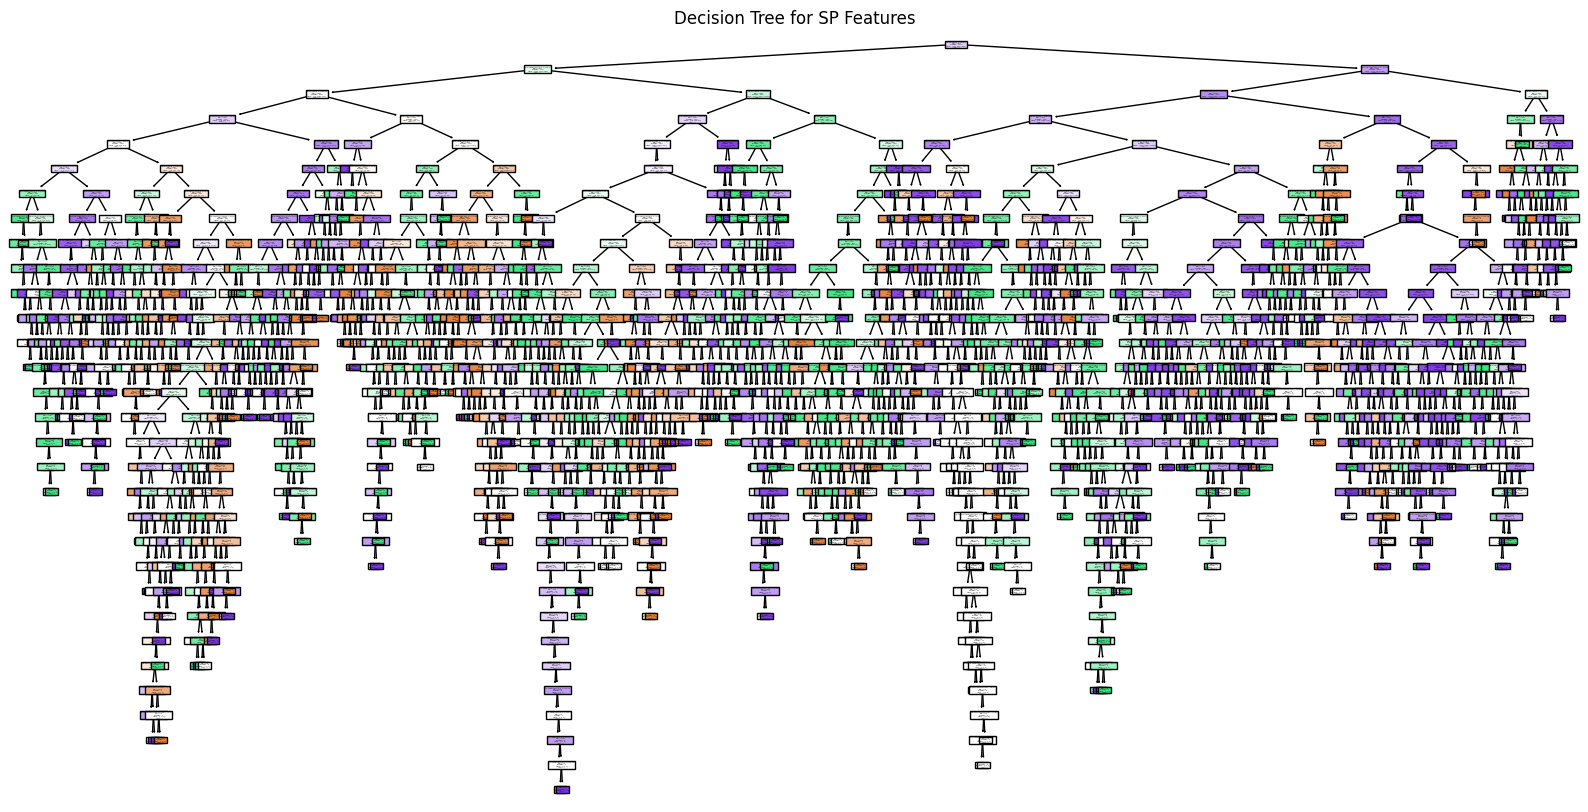

In [39]:
# Train a decision tree model
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import export_text, plot_tree

# Initialize the model
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(X, y)

tree_text = export_text(model, feature_names=X.columns.tolist())
print(tree_text)

# Visualize the decision tree
plt.figure(figsize=(20, 10))
# plot_tree(model, feature_names=X, class_names=[str(cls) for cls in model.classes_], filled=True)
plot_tree(model, feature_names=X.columns, class_names=[str(cls) for cls in model.classes_], filled=True)

plt.title("Decision Tree for SP Features")
plt.show()